In [28]:
import numpy as np
from itertools import combinations
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector, partial_trace
from qclib.state_preparation import MixedInitialize
from qclib.machine_learning.datasets import digits
from qclib.entanglement import schmidt_decomposition
from qclib.state_preparation.util.baa import _split_combinations

# If you are not using the `qdna-lib` source code,
# comment out the following two lines.
import sys
sys.path.append('../../qdna-lib/')

from qdna.compression import SchmidtCompressor

In [29]:
# Dataset load.
seed = 42

# Here you can choose the dataset classes. For example: [3], [0,1], [1,8], [2,4,7], etc.
sample_total, training_input, test_input, class_labels = digits.load(classes=[0,1],
                                                                     training_size=160,
                                                                     test_size=10,
                                                                     random_seed=seed)
feature_dim = len(training_input[class_labels[0]][0])
n_qubits = int(np.ceil(np.log2(feature_dim)))

# Variables to collect data for the summary.
fidelities = [[],[],[]]
figures = [[],[],[]]

In [30]:
# Prints information on training and test datasets.
for _, train_samples in training_input.items():
    print(train_samples.shape)
for _, test_samples in test_input.items():
    print(test_samples.shape)

(160, 64)
(160, 64)
(10, 64)
(10, 64)


In [31]:
# Utility functions.
def calc_fidelity(state1, state2):
    bra = np.conj(state1)
    ket = state2

    return np.power(np.abs(bra.dot(ket)), 2)

def plot_digits(vectors, num_data_qubits, text=''):
    import matplotlib.pyplot as plt
    _dpi = 96
    matrix_dim_1 = 2**(int(np.ceil(num_data_qubits/2)))
    matrix_dim_2 = 2**(int(np.floor(num_data_qubits/2)))

    ncols = len(vectors)
    _, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*10*matrix_dim_1/_dpi, 10*matrix_dim_2/_dpi), dpi=_dpi)
    for ax, vector in zip(axes, vectors):
        ax.set_axis_off()
        image = vector.reshape(matrix_dim_1, matrix_dim_2)
        ax.imshow(image, cmap=plt.cm.gray, interpolation='none')

    plt.show()

***
## Experiment main routine
***

In [32]:
def experiment(test_input, compressor, decompressor, references=None, verbose=1):
    # Applies the compression-decompression process to each of the test samples.

    fidelities = []
    figures = []

    # Info about the auxiliary space.
    aux_zero = [1]
    n_aux_qubits = 0
    if references is not None:
        len_aux = references[0][0].num_qubits // 2
        n_aux_qubits = len_aux * len(references[0])
        aux_zero = [1] + [0] * (2**n_aux_qubits-1)
        aux_qubits = np.array(range(n_qubits, n_qubits+n_aux_qubits))

    # Iterates through all test samples.
    for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
        initializer = StatePreparation(test_sample)

        # Circuit on Alice's side.
        circuit = QuantumCircuit(n_qubits + n_aux_qubits)
        circuit.append(initializer.definition, range(n_qubits))
        circuit.append(compressor.definition, range(n_qubits))
        circuit.reset(compressor.trash_qubits)

        # Circuit on Bob's side.
        if references is not None:
            trash_qubits = np.array(compressor.trash_qubits)
            for j, ref_initializer in enumerate(references[i]):
                qubits_idx = list(range(j * len_aux, (j+1) * len_aux))
                circuit.compose(
                    ref_initializer.definition,
                    [*aux_qubits[qubits_idx], *trash_qubits[qubits_idx]],
                    inplace=True
                )
        circuit.append(decompressor.definition, range(n_qubits))

        # Measures the recovered state and compares it with the original state.
        #
        # There is a sporadic bug in the reset.
        # For now, I've decided to run the same piece of code five
        # times to avoid it, but at some point it will be necessary
        # to investigate the problem.
        output_probs = None
        fidelity = 0.0
        for _ in range(10):
            state_vector = Statevector(circuit)
            _output_state = state_vector.data
            _fidelity = calc_fidelity(np.kron(aux_zero, test_sample), _output_state)
            if _fidelity > fidelity:
                fidelity = _fidelity
                output_probs = state_vector.probabilities(range(n_qubits))

        # Stores and prints the results.
        fidelities.append(fidelity)
        figures.append([np.abs(test_sample)**2, output_probs])
        if verbose > 0:
            print(i, '- Recovered state fidelity =', fidelity)
        if verbose > 1:
            plot_digits([np.abs(test_sample)**2, output_probs], n_qubits)

    return fidelities, figures

In [33]:
# Creates an example of the circuit.
def complete_circuit(compressor, decompressor, references=None):
    
    # Random typical state.
    typical_state = np.random.rand(2**n_qubits)
    typical_state = typical_state / np.linalg.norm(typical_state)

    # Typical state initializer.
    initializer = StatePreparation(typical_state)

    # Info about the auxiliary space.
    n_aux_qubits = 0
    if references is not None:
        len_aux = references[0][0].num_qubits // 2
        n_aux_qubits = len_aux * len(references[0])
        aux_qubits = np.array(range(n_qubits, n_qubits + n_aux_qubits))

    # Creates the quantum circuit.
    circuit = QuantumCircuit(n_qubits + n_aux_qubits)

    # Circuit on Alice's side.
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))
    circuit.reset(compressor.trash_qubits)
    
    # Circuit on Bob's side.
    if references is not None:
        circuit.barrier()
        trash_qubits = np.array(compressor.trash_qubits)
        for i, ref_initializer in enumerate(references[0]):
            qubits_idx = list(range(i * len_aux, (i+1) * len_aux))
            circuit.compose(
                ref_initializer.definition,
                [*aux_qubits[qubits_idx], *trash_qubits[qubits_idx]],
                inplace=True
            )
        circuit.barrier()
    circuit.append(decompressor.definition, range(n_qubits))

    return circuit    

***
## Calculates the typical state
***

In [34]:
# Estimate the centroid.
# Simply the average of the training samples (or a random selection of samples).

centroid = np.zeros(2**n_qubits)
for train_sample in np.concatenate([train_samples for _, train_samples in training_input.items()]):
    centroid += train_sample

typical_state = centroid / np.linalg.norm(centroid)

print(typical_state.shape)

(64,)


In [35]:
np.linalg.norm(typical_state)

1.0

***
## Find the best partitioning configuration.
***

In [36]:
# Defines the number of latent qubits.
# `0 < n_latent_qubits < n_qubits`.
n_latent_qubits = n_qubits // 2

n_trash_qubits = n_qubits - n_latent_qubits

def von_neumann_entropy(singular_values):
    squared_singular_values = np.power([s for s in singular_values if s >= 1e-17], 2)
    return -np.sum(squared_singular_values * np.log(squared_singular_values))

# Set `min_entropy` equal to the maximum entropy for the system.
min_entropy = von_neumann_entropy(
    [1/np.sqrt(2**n_latent_qubits)] * 2**n_latent_qubits
)

for trash_qubits in _split_combinations(range(n_qubits), n_trash_qubits):
    rank, svd_u, singular_values, svd_v = schmidt_decomposition(
        typical_state, trash_qubits, rank=0, svd='auto'
    )

    entropy = von_neumann_entropy(singular_values)

    print('trash_qubits', trash_qubits, 'entropy', entropy)
    if entropy <= min_entropy:
        min_entropy = entropy
        latent_qubits = sorted(set(range(n_qubits)).difference(set(trash_qubits)))

trash_qubits (0, 1, 2) entropy 0.2671940046300695
trash_qubits (0, 1, 3) entropy 0.9286829198048681
trash_qubits (0, 1, 4) entropy 0.9405683918342369
trash_qubits (0, 1, 5) entropy 0.4312852752224746
trash_qubits (0, 2, 3) entropy 0.9722818204677055
trash_qubits (0, 2, 4) entropy 0.9615693411987976
trash_qubits (0, 2, 5) entropy 0.43194813154194395
trash_qubits (0, 3, 4) entropy 0.3896715799342443
trash_qubits (0, 3, 5) entropy 0.9311020598127034
trash_qubits (0, 4, 5) entropy 0.948098211267135


In [37]:
print('Best channel:', latent_qubits)

Best channel: [3, 4, 5]


***
## Creates the compressor and the decompressor
***

In [38]:
# Creates the compressor.

# These are the qubits of the quantum channel for data transmission.
# It can take on any configuration. For example: [0], [0,1,2,3,4], [1,3,5], etc.
# latent_qubits = [3,4,5]

compressor = SchmidtCompressor(typical_state, opt_params={'partition': latent_qubits, 'lr': 0})
decompressor = compressor.inverse()

***
## Experiment without optimization
***
Using |0> as the reference state.


### Draw an example of the circuit


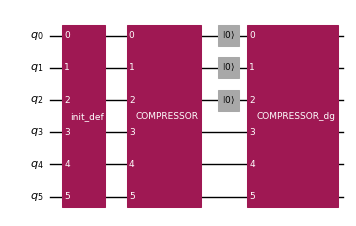

In [39]:
circuit = complete_circuit(compressor, decompressor)
# Draw the circuit diagram.
circuit.draw('mpl', scale=0.5, style="iqp")

### Run the experiment without optimization

0 - Recovered state fidelity = 0.9205221343622257


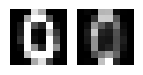

1 - Recovered state fidelity = 0.8101124343641004


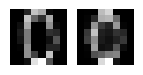

2 - Recovered state fidelity = 0.9167057773608935


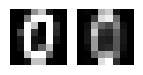

3 - Recovered state fidelity = 0.8707497611790435


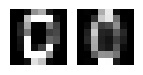

4 - Recovered state fidelity = 0.7489445921175792


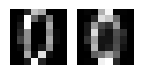

5 - Recovered state fidelity = 0.8409808824543301


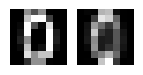

6 - Recovered state fidelity = 0.8765367123901685


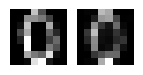

7 - Recovered state fidelity = 0.7817234146998604


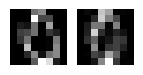

8 - Recovered state fidelity = 0.7853216388614346


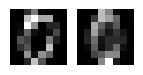

9 - Recovered state fidelity = 0.814195455721713


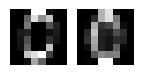

10 - Recovered state fidelity = 0.6751952411300457


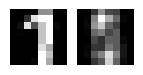

11 - Recovered state fidelity = 0.7375150544553848


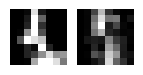

12 - Recovered state fidelity = 0.5208767211617339


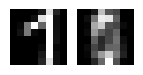

13 - Recovered state fidelity = 0.7099670371186245


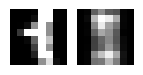

14 - Recovered state fidelity = 0.7000503563796691


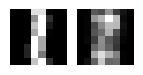

15 - Recovered state fidelity = 0.6852100610981271


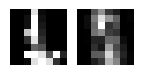

16 - Recovered state fidelity = 0.6418587620467568


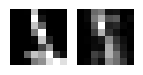

17 - Recovered state fidelity = 0.8228896357033716


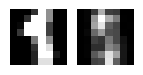

18 - Recovered state fidelity = 0.834116592839574


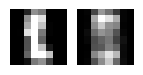

19 - Recovered state fidelity = 0.5577891277945837


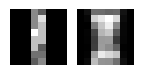

In [40]:
fidelities[0], figures[0] = experiment(
    test_input,
    compressor,
    decompressor,
    verbose=2
)

***
## Experiment with optimization 1
***
This optimization is based on the conservation of entropy.
As we are dealing with a pure state (Alice's side), our goal is to produce an initial state of zero entropy (or close to zero) on Bob's side.

### Constructs the set of gates to initialize the mixed-states.

In [41]:
# Applies the compression process to each of the train samples,
# calculates the correspondent trash state,
# and stores the correspondent mixed state initializer gate.

references_1 = []
for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = StatePreparation(test_sample)

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    trash_state = partial_trace(Statevector(circuit), compressor.latent_qubits)
    references_1.append([
        MixedInitialize(trash_state.data.T, classical=True, reset=True)
    ])

### Draw an example of the reference state initializer

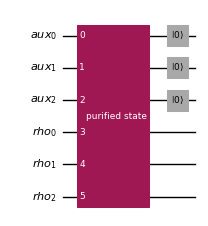

In [42]:
references_1[0][0].definition.draw('mpl', scale=0.5, style="iqp")

### Draws an example of the complete circuit

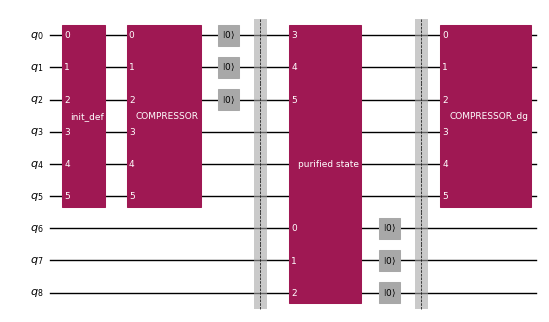

In [43]:
circuit = complete_circuit(compressor, decompressor, references_1)
# Draw an example of the circuit.
circuit.draw('mpl', scale=0.5, style="iqp")

## Optimized experiment:
Uses the exact trash state as the reference state.
This relies on classical communication, as the trash state must be transmited between Alice and Bob for each execution.

In [44]:
fidelities[1], figures[1] = experiment(
    test_input,
    compressor,
    decompressor,
    references=references_1,
    verbose=1
)

0 - Recovered state fidelity = 0.9488067461406064
1 - Recovered state fidelity = 0.8418067356224022
2 - Recovered state fidelity = 0.9386105815365916
3 - Recovered state fidelity = 0.8928516973874786
4 - Recovered state fidelity = 0.8315858467914228
5 - Recovered state fidelity = 0.9076674173054692
6 - Recovered state fidelity = 0.9153569632155247
7 - Recovered state fidelity = 0.8262147416727622
8 - Recovered state fidelity = 0.8402005052618523
9 - Recovered state fidelity = 0.8226684719306091
10 - Recovered state fidelity = 0.8791811384626418
11 - Recovered state fidelity = 0.7876358106431824
12 - Recovered state fidelity = 0.806226582001115
13 - Recovered state fidelity = 0.879144790401407
14 - Recovered state fidelity = 0.9468603283144288
15 - Recovered state fidelity = 0.7923116635639793
16 - Recovered state fidelity = 0.7221433761149022
17 - Recovered state fidelity = 0.8816281947458785
18 - Recovered state fidelity = 0.9314034530763164
19 - Recovered state fidelity = 0.965010607

***
## Experiment with optimization 2
***
This optimization reduces the cost of the previous one by relying on single-qubit tomography. That way, the cost of the tomography is linear on the number of trash qubits, O(n_t), and the cost of the classical communication is also O(n_t).

### Constructs the set of gates to initialize the mixed-states.

In [45]:
references_2 = []

for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = StatePreparation(test_sample)

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    single_qubit_initializers = []
    for trash_qubit in compressor.trash_qubits:
        trash_qubits = list(set(compressor.trash_qubits) - set([trash_qubit]))
        trash_state = partial_trace(Statevector(circuit), trash_qubits + compressor.latent_qubits)
        single_qubit_initializers.append(
            MixedInitialize(trash_state.data.T, classical=True, reset=True)
        )

    references_2.append(single_qubit_initializers)

### Draw an example of the reference state initializer

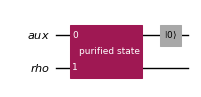

In [46]:
references_2[0][0].definition.draw('mpl', scale=0.5, style="iqp")

### Draw an example of the complete circuit

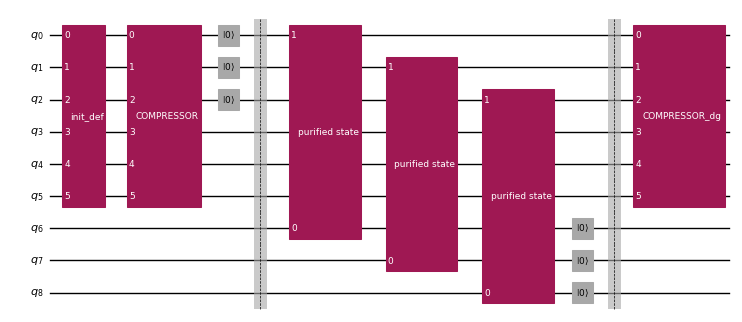

In [47]:
circuit = complete_circuit(compressor, decompressor, references_2)
# Draw an example of the circuit.
circuit.draw('mpl', scale=0.5, style="iqp")

## Optimized experiment:
Uses the single-qubit trash states as the reference state.
This relies on classical communication, as the trash state must be transmited between Alice and Bob for each execution, but the cost is only O(n_t).

In [48]:
fidelities[2], figures[2] = experiment(
    test_input,
    compressor,
    decompressor,
    references=references_2,
    verbose=1
)

0 - Recovered state fidelity = 0.9441165015201232
1 - Recovered state fidelity = 0.8395934537419419
2 - Recovered state fidelity = 0.9368949589792828
3 - Recovered state fidelity = 0.8913682988497345
4 - Recovered state fidelity = 0.8157897743185247
5 - Recovered state fidelity = 0.9004532743521587
6 - Recovered state fidelity = 0.9128572982806876
7 - Recovered state fidelity = 0.8110119936687804
8 - Recovered state fidelity = 0.8224669938307401
9 - Recovered state fidelity = 0.8209232072924306
10 - Recovered state fidelity = 0.7311922046480941
11 - Recovered state fidelity = 0.7565602259126003
12 - Recovered state fidelity = 0.6678443830122908
13 - Recovered state fidelity = 0.7720841606720775
14 - Recovered state fidelity = 0.9298192239437724
15 - Recovered state fidelity = 0.7228720237152233
16 - Recovered state fidelity = 0.6791769919384526
17 - Recovered state fidelity = 0.8551870345188269
18 - Recovered state fidelity = 0.895714172143219
19 - Recovered state fidelity = 0.91891447

***
## Summary
***

In [49]:
for i, (item1, item2, item3) in enumerate(zip(fidelities[0],fidelities[1],fidelities[2])):
    print(i, '-', item1, item2, item3)

0 - 0.9205221343622257 0.9488067461406064 0.9441165015201232
1 - 0.8101124343641004 0.8418067356224022 0.8395934537419419
2 - 0.9167057773608935 0.9386105815365916 0.9368949589792828
3 - 0.8707497611790435 0.8928516973874786 0.8913682988497345
4 - 0.7489445921175792 0.8315858467914228 0.8157897743185247
5 - 0.8409808824543301 0.9076674173054692 0.9004532743521587
6 - 0.8765367123901685 0.9153569632155247 0.9128572982806876
7 - 0.7817234146998604 0.8262147416727622 0.8110119936687804
8 - 0.7853216388614346 0.8402005052618523 0.8224669938307401
9 - 0.814195455721713 0.8226684719306091 0.8209232072924306
10 - 0.6751952411300457 0.8791811384626418 0.7311922046480941
11 - 0.7375150544553848 0.7876358106431824 0.7565602259126003
12 - 0.5208767211617339 0.806226582001115 0.6678443830122908
13 - 0.7099670371186245 0.879144790401407 0.7720841606720775
14 - 0.7000503563796691 0.9468603283144288 0.9298192239437724
15 - 0.6852100610981271 0.7923116635639793 0.7228720237152233
16 - 0.64185876204675

0


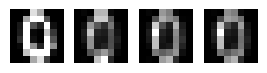

1


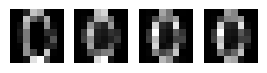

2


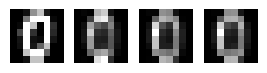

3


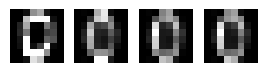

4


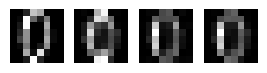

5


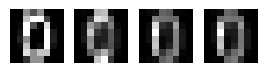

6


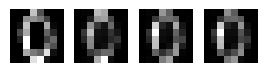

7


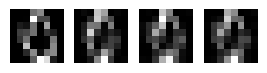

8


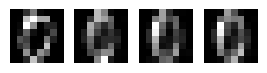

9


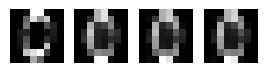

10


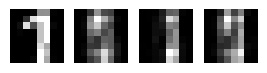

11


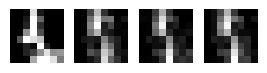

12


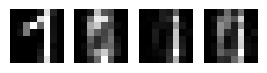

13


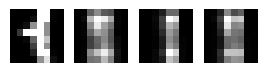

14


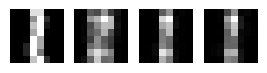

15


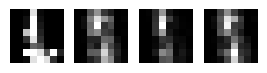

16


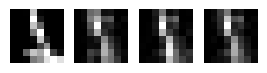

17


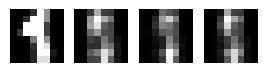

18


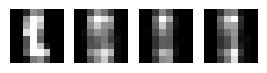

19


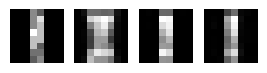

In [50]:
for i, (item1, item2, item3) in enumerate(zip(figures[0],figures[1],figures[2])):
    print(i)
    plot_digits([item1[0], item1[1], item2[1], item3[1]], n_qubits)